Vineet Belur, 109211326

<a/ id='top'></a>

# CSCI4022 Homework 4; GMMs

## Due Monday, February 21 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |
---


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Theory: GMM; 5 pts) 
In the GMM slides, we stated that the weights $w_m$ of the 1-dimensional GMM with pdf

$f(x|\theta)=w_1\phi(x|\mu_1, \sigma_1^2)+w_2\phi(x|\mu_2, \sigma_2^2)+\dots+ w_m\phi(x|\mu_m, \sigma_m^2)$

required the weights to sum to one.  

#### a) Use the following markdown cell to prove this statement.  In a sentence, describe how this proof might change in higher dimensions.

Our weights are estimated via MLE. Our weights correspond to the probabilities of the parameters given the inp mean/variance. As such, if the summation of our weights were greater than 1 we would be breaking the law of total probability. 

This proof might change in higher dimensions are our weights are intrisically approximations. As our number of features grows, so does the number of floating point numbers. We might have weights that sum to values that are minutely larger than 1.

#### b) Is it possible to have a valid pdf $f(x)$ above if any of the weights $w_k$ are negative?  If not, why not?  If so, what other difficulties might be associated with negative weights?

A pdf has two properties:

1. $f(x)\geq0$, for all x
2. $\int_{-\infty}^{\infty}f(x)dx=1$

If we had negative weights this would break property one, thereby invalidating the pdf f(x). 

One potential disadvantage of having negative weights that comes to mind is convergence. If we had negative weights we might reach positions where our weights continuously increase and decrease without any point of convergence. Alongside this, negative weights don't really make sense when considering anything other than continuous variables. 

***

<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (Choose a k? 25 pts)

Continuing with the Pokémon theme of HW3's clustering, we have a data set of geolocated Pokémon Go "spawns" taken from the bay area around San Francisco, CA, US.  What results is a map that should loosely approximate the population density of the San Francisco Bay, with some adjustments according to the weights that Pokémon Go uses (I believe this means more things happen in parks, for example), and some bias due to using cell phone usage as a measure for population location.  The set includes:


`lat`: numeric,	Latitude of spawn

`lng`:	numeric,	Longitude

`name`: which Pokémon spawned at each location (you may discard this if desired).

For all prompts, use Euclidean distance ($L_2$).

(**NB**: using Euclidean distance on lat/lon data is not technically correct, you classically have to *project* locations onto a 2D map or find their true great-circle distances apart.  We will ignore this here, as the region is small enough to have only minor error due to ignoring curvature of the surface.)

Here we will focus on the locational problem of latitude versus longitude.  As in kmeans, instead of choosing $k$ we might choose a variety of values of $k$ and implement a GMM for each.

Shown below is the lat/lon locations of the Pokémon.  Not only is there structure, it has a shape: some data appears in lines that aren't perfect circles.  This is a perfect task for the GMM!

         lat         lng     name
0  37.361151 -122.014794   Cubone
1  37.835080 -122.477904  Spearow
2  37.322755 -121.976948  Rattata


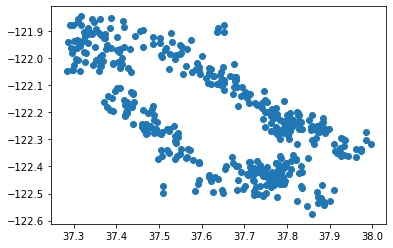

In [2]:
df=pd.read_csv('../data/bayareapokemon.csv', encoding='UTF-8')
print(df.head(3))
plt.scatter(df['lat'], df['lng'])
df=df.drop(columns='name')

**Part A**:  Write (by hand) a function `GMM(dat, k, init=...)` that performs the EM algorithm for a Gaussian mixture model on a given set of $(X,Y)$ locational data.  You may include random initialization inside the function or as an input.

You should run the algorithm for sufficient steps until convergence, and should return at a minimum, the means, 2x2 covariance matrices, and mixture probabilities of each component.  You may also want to return the responsibilities of each datum to the k components for later use, but this is less necessary.

In [3]:
def weighted_mean(dat, pmi, nm, means):
    #pmi/nm should be k-len, can just extract
    for x in range(0, len(pmi)):
        mux = np.sum(np.dot(dat[:,0],pmi[x]))/nm[x]
        muy = np.sum(np.dot(dat[:,1],pmi[x]))/nm[x]
        means[x] = np.array([mux,muy]) #kx2
    return means

def weighted_covars(dat,pmi,nm,covars,means):
    for x in range(0, len(pmi)):
        #sum((Xi-meani)*(Xi-meani)
        X = dat[:,0] - means[x][0]
        Y = dat[:,1] - means[x][1]

        xx = np.dot(X**2, pmi[x])/nm[x]
        xy = np.dot(X*Y, pmi[x])/nm[x]
        #might as well not bother computing yx -> same thing as xy, obv would change in 3d/4d/etc. -> we only
        #really need the upper triangle of covariances tho(reiterative otherwise)
        yy = np.dot(Y**2, pmi[x])/nm[x]
        covars[x] = np.array([[xx,xy],[xy,yy]])
    return covars

def mean_distance(dat, means, p_class_given_data):
    md = 0
    for x in range(len(dat)):
        for y in range(0, len(p_class_given_data)):
            md += p_class_given_data[y][x]*((dat[x][0]-means[y][0])**2)
            md += p_class_given_data[y][x]*((dat[x][1]-means[y][1])**2)
    return (md/len(dat))**(1/2)

In [4]:
def GMM(dat, k):
    #we are going to take in dat as a numpy array
    dat_index = np.arange(len(dat))
    r = np.random.choice(dat_index, size=k)
    means = np.array([x for x in dat[r]])

    covar = np.cov(dat[:,0], dat[:,1])
    #note: We will need to redeclare the inside of our arrays here
    #as its currently just all pointing to the same object
    #we will have our subroutine deal w this.
    covars = [covar for i in range(0, k)] 
    #m 2x2 covar of xx,xy,yx,yy array
    p_class_given_data = [0]*k #list of nparrays
    p_class = np.array([1/k for i in range(0, k)])
    #initialize as equal
    mean_dist, prev_dist = None, None
    tol = float("inf")
    #ran k=3 to find where we converge -> if our k value is too high then we might have a value of tol that is too large
    #for lower values of k. We expect higher mean distance when we have more clusters typically - perhaps
    #this behavior would not be expected if our #of points was much larger tho.
    while tol >= 0.00001:
        #EXPECTATION PHASE - 
        summ = np.zeros(len(dat))
        for x in range(0, k):
        #p(mi)/sum(pmi)
            p_data = stats.multivariate_normal.pdf(dat, mean=means[x], cov=covars[x])
            p_class_given_data[x] = p_data*p_class[x]
            summ += p_class_given_data[x] 
        p_class_given_data = [p_class_given_data[i]/summ for i in range(k)]
        #print(np.sum(p_class_given_data)) #just make sure that this adds up to 450
        #MAXIMIZATION PHASE - 
        #firstly get nm -> for wm/mu/covar
        n_class = [np.sum(p_class_given_data[i]) for i in range(k)]
        #now update wm
        p_class = [n_class[i]/len(dat) for i in range(k)]
        #now update mu 
        means = weighted_mean(dat,p_class_given_data,n_class,means)
        #finally update our covariance matrix
        covars = weighted_covars(dat,p_class_given_data,n_class,covars,means)    
        #and we're done!
        prev_dist = mean_dist
        mean_dist = mean_distance(dat, means, p_class_given_data)
        #here we try to discern convergence.
        if prev_dist:
            tol = prev_dist - mean_dist
            
    return p_class_given_data, means, covars, p_class, mean_dist

In [5]:
dat = df.to_numpy()
p_class_given_data, means, covars, p_class, mean_dist = GMM(dat, 5)

**Part B**: 

Run your algorithm for $k=[1,2,3,4,5,6,7,8]$, then create an **elbow plot** of the weighted-mean-distance to component for each choice of $k$.

To compute this, take a clustering and its responsibilities $p_{mi}$, then compute the average distance between each point and each cluster, weighted by $p_{mi}$:

$$ \bar{D} = \sqrt{\frac{\sum^n_{i=1}\sum^k_{m=1} p_{mi} (x_i-\mu_m)^2}{n}}$$

(**Idea**: this averages the distance between each point and the 'closest' cluster, but allows for the soft-clustering nature of points to compute distances between multiple clusters.)


Create your elbow plot by making a line plot of the values of $\bar{D}$ against $k$.

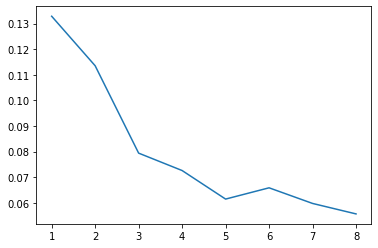

In [6]:
weighted_dist = np.zeros(8)
dat = df.to_numpy()
for k in range(1,9):
#p_class_given_data, means, covars, p_class, mean_dist
    mean_weighted_dist = np.zeros(5)
    for x in range(0, 5):
        _, _, _, _, mean_weighted_dist[x] = GMM(dat, k)
    weighted_dist[k-1] = np.sum(mean_weighted_dist)/10
plt.plot([i for i in range(1,9)], weighted_dist)

just ran these a few times to get a mean weighted mean distance - was having high-ish variance otherwise.

**Part C**: 

Based on the plot in part **B**, what looks like the best choice of $k$ for this problem?  Are multiple values in contention?  Explain, and then plot your preferred choice of $k$ where you color each data point according to the cluster with which it has the highest responsibility (i.e. hard cluster based on responsibilities).

Looks like k=3 or k=5. This curve is a LOT smoother than the k-means elbow plot was. This might be due to the size of our distance values here being much smaller or rather that our previous data set had a much more logical ordering.

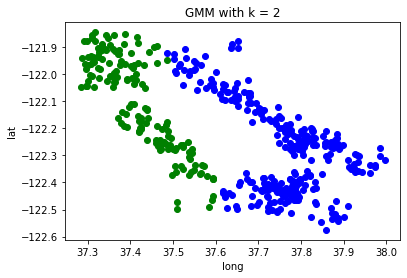

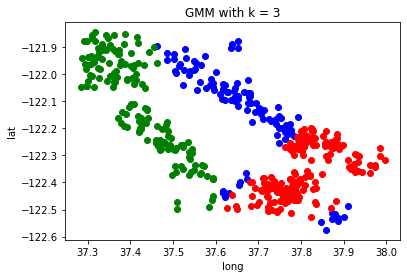

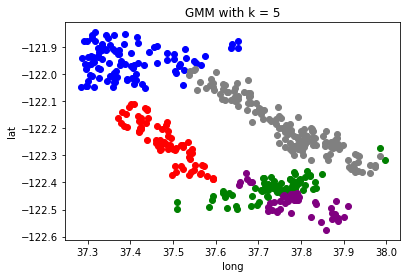

In [12]:
dat = df.to_numpy()
def plot_stuff(k):
    ax = plt.subplots()
    plt.title(f"GMM with k = {k}")
    plt.xlabel("long")
    plt.ylabel("lat")
    color = ["blue", "green", "red", "purple", "grey"]
    p_class_given_data, means, covars, p_class, mean_dist = GMM(dat, k)
    to_color = [[] for i in range(0, k)]
    for x in range(0, len(dat)):
        biggest,ind = float("-inf"), None
        for y in range(0, k):
            if biggest < p_class_given_data[y][x]:
                biggest = p_class_given_data[y][x]
                ind = y
        to_color[ind].append(x)
    for x in range(0, k):
        vals = dat[to_color[x]]
        plt.scatter(vals[:,0], vals[:,1], c=color[x])
    plt.show()
plot_stuff(2)
plot_stuff(3)
plot_stuff(5)

***
<a/ id='p3'></a>
[Back to top](#top)
# Problem 3 (Simulation on the GMM; 15 pts)


Because the GMM is a *generative* model, we could use our results from Problem 2 to not only score models based on their mean-distance-to-centroid (or other statistical measures like AIC, BIC), we could simulate points from the models and visually ascertain whether or not they appear similar to the original distribution.

**Part A**: 

For each of the GMM models in Problem 2 from $k=[2,3,4,5,6,7,8]$, simulate 1000 points from your estimated density function (recall: this is a two-part simulation of choosing a component **then** drawing from the normal of appropriate mean/covariance).

Create a figure with 2 columns and 4 rows holding all 8 data sets: the 7 simulated ones and the original data shown above.  Label each plot appropriately.  

In [8]:
sim_points = np.zeros([7,1000,2])

for x in range(2,9):
    sim = np.zeros([1000,2])
    p_class_given_data, means, covars, p_class, mean_dist = GMM(dat, x)
    for y in range(0, 1000):
        choice = np.random.choice([i for i in range(x)])
        #We now choose a random sample from our multivariate_normal with associated mean/covariance
        sim[y] = np.random.multivariate_normal(mean=means[choice], cov=covars[choice])
    sim_points[x-2] = sim

Text(0, 0.5, 'long')

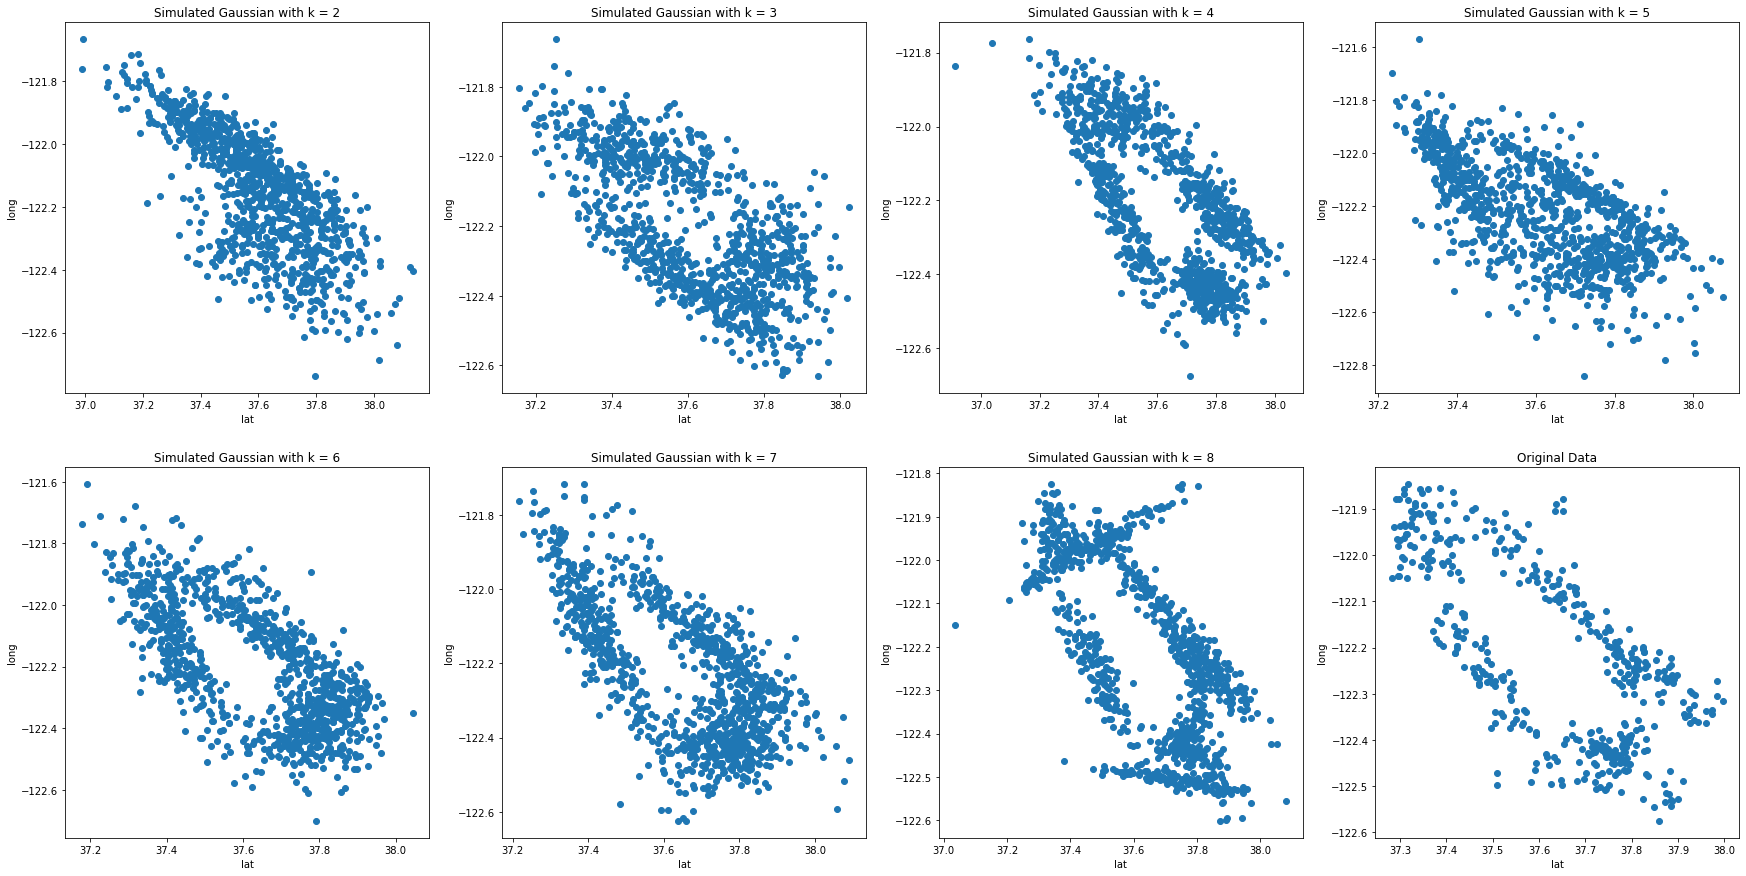

In [11]:
fig, ax = plt.subplots(2,4,figsize=(30, 15))
k = [[0,1,2,3],[4,5,6,None]] #idk i got lazy
for x in range(0,2):
    for y in range(0,4):
        if k[x][y] != None:
            ax[x][y].scatter(sim_points[k[x][y]][:,0], sim_points[k[x][y]][:,1])
            ax[x][y].set_title(f"Simulated Gaussian with k = {k[x][y] + 2}")
            ax[x][y].set_xlabel("lat")
            ax[x][y].set_ylabel("long")
ax[1][3].scatter(dat[:,0], dat[:,1])
ax[1][3].set_title("Original Data")
ax[1][3].set_xlabel("lat")
ax[1][3].set_ylabel("long")

In [10]:
sim_points.shape

(7, 1000, 2)

**Part B**: 


Which plot or plots look closest to the original data?  Depending on your interpretations of the elbow plot versus the simulated data, you may have decided that we wanted a different value of $k$ for the best model to *simulate* from rather than the best model to *cluster* or classify upon.  Do you think that this is normally the case?  Why or why not?  What properties of a data set would make one task easier or harder with more or less $k$?

Plots with k=3 and k=5 look closest to the original data, specifically k=5 here. 

I didn't end up choosing a different k-value based on the simulation, however it is very possible that this is case, especially with elbow plots that are especially smooth. If we have a very discrete point where we can see our elbow plot bend then it is likely we have found the best k value. On the other hand, when we simulate we also incur a lot of randomness, so it would be important to simulate each k value multiple times and confirm our choice for k-value. 

If our dataset was especially small it would make it much harder to find the best model to cluster on as our model would only be trained on a small subsample, so outliers would greatly effect the values of our mu/covar.